<a href="https://colab.research.google.com/github/BarryS27/Sleep-Alcohol-Adult-Mental-Heatlth/blob/main/BRFSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata

!pip install -q kaggle

if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"' + userdata.get('KAGGLE_USERNAME') + '","key":"' + userdata.get('KAGGLE_KEY') + '"}')
os.chmod('/root/.kaggle/kaggle.json', 600)

!kaggle datasets download -d cdc/behavioral-risk-factor-surveillance-system
!unzip -o behavioral-risk-factor-surveillance-system.zip

Dataset URL: https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system
License(s): CC0-1.0
 93% 385M/414M [00:00<00:00, 465MB/s]
100% 414M/414M [00:00<00:00, 492MB/s]
Archive:  behavioral-risk-factor-surveillance-system.zip
  inflating: 2011.csv                
  inflating: 2012.csv                
  inflating: 2013.csv                
  inflating: 2014.csv                
  inflating: 2015.csv                
  inflating: 2015_formats.json       


In [ ]:
health = pd.read_csv('2013.csv', encoding='cp1252', low_memory=False)

In [ ]:
required_cols = ['MENTHLTH', 'PHYSHLTH', 'SLEPTIM1', 'ALCDAY5']
for col in required_cols:
    if col not in health.columns:
        print(f"Warning：Column {col} doesn't exist!")

health_clean = health[required_cols].copy()

health_clean = health_clean.rename(columns={
    'MENTHLTH': 'MentalHealth',
    'PHYSHLTH': 'PhysicalHealth',
    'SLEPTIM1': 'SleepTime',
    'ALCDAY5': 'AlcoholDrinking'
})

health_clean['MentalHealth'] = health_clean['MentalHealth'].replace({88: 0, 77: pd.NA, 99: pd.NA})
health_clean['PhysicalHealth'] = health_clean['PhysicalHealth'].replace({88: 0, 77: pd.NA, 99: pd.NA})
health_clean['SleepTime'] = health_clean['SleepTime'].replace({77: pd.NA, 99: pd.NA})

def clean_alcohol(x):
    if x == 888:
        return 'Non-drinker'
    elif 100 <= x <= 230:
        return 'Drinker'
    else:
        return np.nan

health_clean['AlcoholDrinking'] = health_clean['AlcoholDrinking'].apply(clean_alcohol)

health_clean = health_clean.dropna()
health_sub = health_clean.loc[(health_clean["SleepTime"] < 15) & (health_clean["SleepTime"] > 2)].copy()

print("\n")
display(health_sub.head())

,MentalHealth,PhysicalHealth,SleepTime,AlcoholDrinking
1,0.0,0.0,6.0,Non-drinker
2,2.0,3.0,9.0,Drinker
3,0.0,2.0,8.0,Drinker
4,2.0,10.0,6.0,Drinker
5,0.0,0.0,8.0,Non-drinker


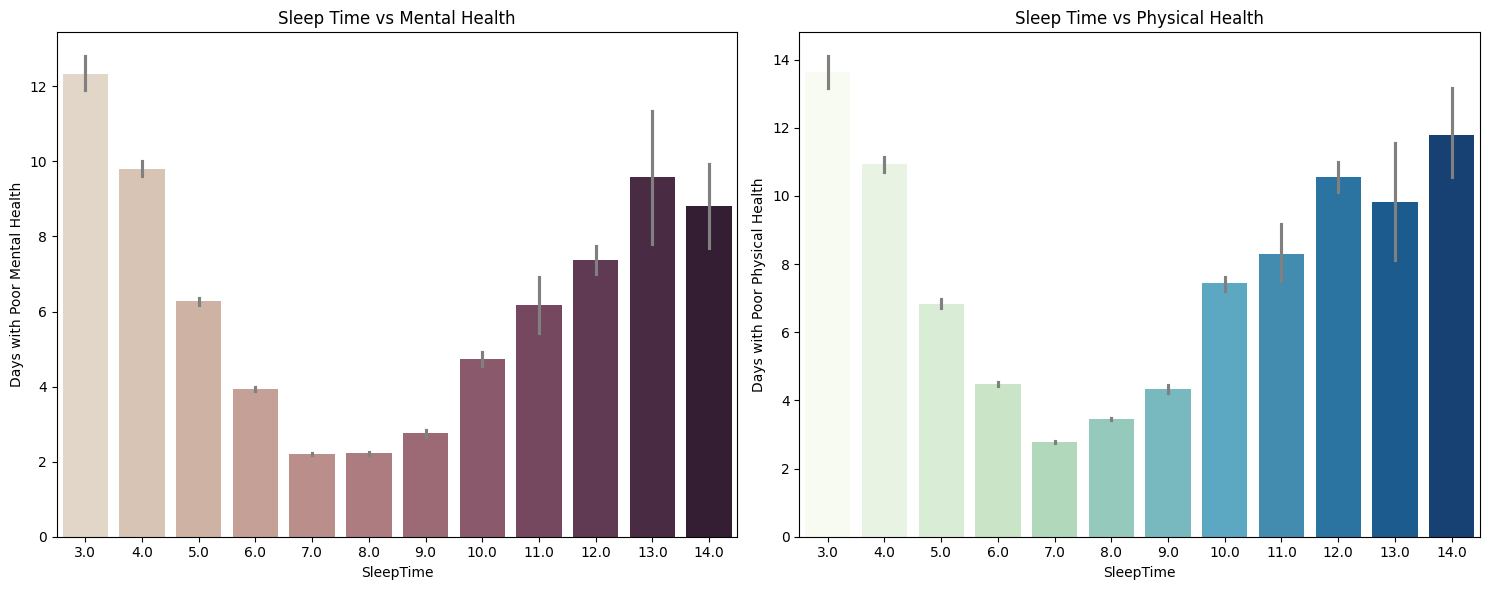

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(
    data=health_sub, x='SleepTime', y='MentalHealth',
    hue='SleepTime', legend=False,
    err_kws={'color': 'grey'},
    palette='ch:.25', ax=axes[0]
)
axes[0].set_title('Sleep Time vs Mental Health')
axes[0].set_ylabel('Days with Poor Mental Health')

sns.barplot(
    data=health_sub, x='SleepTime', y='PhysicalHealth',
    hue='SleepTime', legend=False,
    err_kws={'color': 'grey'},
    palette='GnBu', ax=axes[1]
)
axes[1].set_title('Sleep Time vs Physical Health')
axes[1].set_ylabel('Days with Poor Physical Health')

plt.tight_layout()
plt.show()

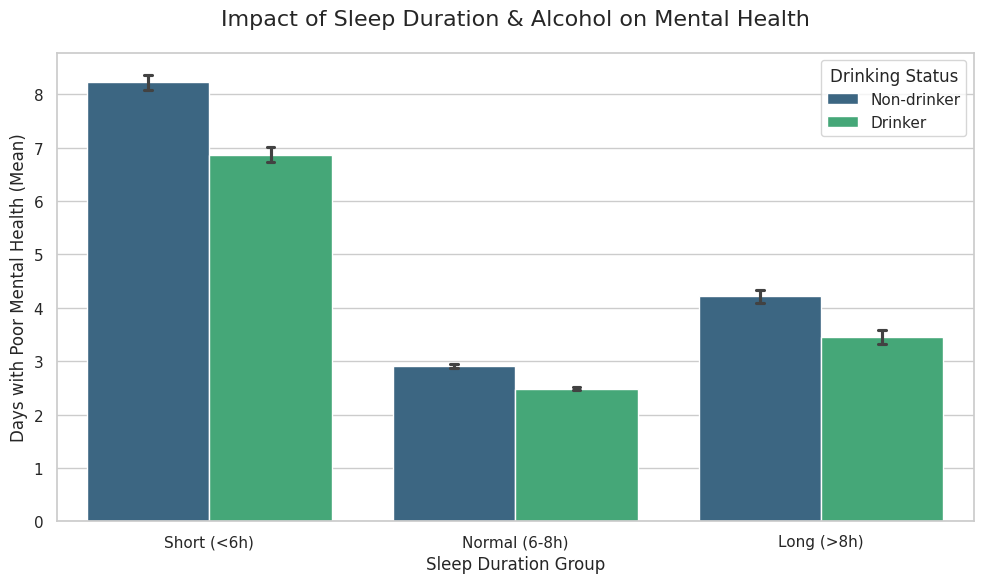

In [ ]:
# Rules: Short (<6h), Normal (6-8h), Long (>8h)
bins = [0, 5, 8, 24]
labels = ['Short (<6h)', 'Normal (6-8h)', 'Long (>8h)']
health_sub['SleepGroup'] = pd.cut(health_sub['SleepTime'], bins=bins, labels=labels)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=health_sub,
    x='SleepGroup',
    y='MentalHealth',
    hue='AlcoholDrinking',
    palette='viridis',
    errorbar=('ci', 95),
    capsize=0.05
)

plt.title('Impact of Sleep Duration & Alcohol on Mental Health', fontsize=16, pad=20)
plt.xlabel('Sleep Duration Group', fontsize=12)
plt.ylabel('Days with Poor Mental Health (Mean)', fontsize=12)
plt.legend(title='Drinking Status')

plt.tight_layout()
plt.show()

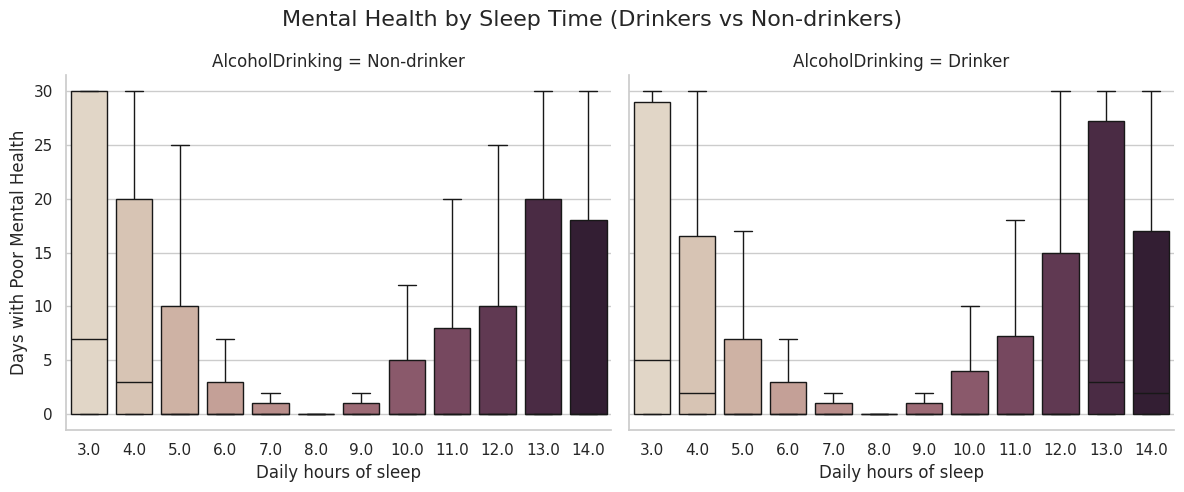

In [ ]:
g = sns.catplot(
    data=health_sub,
    kind='box',
    col='AlcoholDrinking',
    x='SleepTime',
    y='MentalHealth',
    hue='SleepTime',
    palette='ch:.25',
    showfliers=False,
    legend=False,
    height=5, aspect=1.2
)

g.set_axis_labels('Daily hours of sleep', 'Days with Poor Mental Health')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Mental Health by Sleep Time (Drinkers vs Non-drinkers)', fontsize=16)

plt.show()

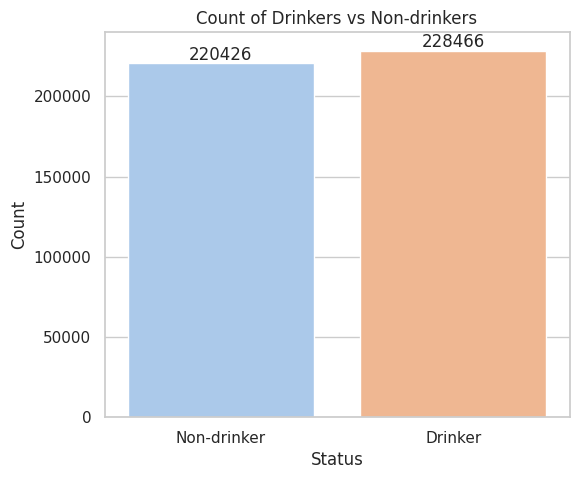

In [ ]:
plt.figure(figsize=(6, 5))

ax = sns.countplot(
    data=health_sub,
    x='AlcoholDrinking',
    hue='AlcoholDrinking',
    legend=False,
    palette='pastel'
)

ax.set_title('Count of Drinkers vs Non-drinkers')
ax.set_xlabel('Status')
ax.set_ylabel('Count')

for container in ax.containers:
    ax.bar_label(container)

plt.show()